### Ch 12: Classification

General overview of incorporating features via Bayesian methods, specifically Naive bayes

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

from os.path import basename, exists
from empiricaldist import Cdf

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://raw.githubusercontent.com/allisonhorst/palmerpenguins/main/inst/extdata/penguins_raw.csv')

def make_cdf_map(df, colname, by='Species2'):
    """Make a CDF for each species."""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

def plot_cdfs(df, colname, by='Species2'):
    """Make a CDF for each species.
    
    df: DataFrame
    colname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, colname, by)
    
    for species, cdf in cdf_map.items():
        cdf.plot(label=species, marker='')
    
    decorate(xlabel=colname,
             ylabel='CDF')

In [2]:
df = pd.read_csv('penguins_raw.csv')
df.shape

def shorten(species):
    return species.split()[0]

df['Species2'] = df['Species'].apply(shorten)

df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,Species2
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.,Adelie
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN,Adelie
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN,Adelie
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.,Adelie
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN,Adelie


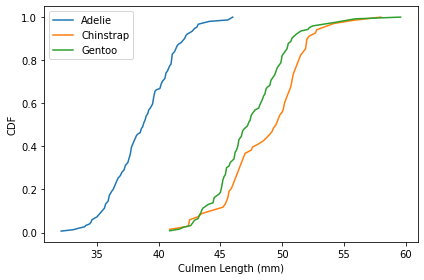

In [3]:
colname = 'Culmen Length (mm)'
plot_cdfs(df, colname)

#### Plotting Cumulative Distribution Functions

This is going to allow us to understand if the typical range of values for feature of interest (Culmen length here) will allow us to differentiate species from one another.

In the above it looks like we could use `Culmen length` to separate `Adelie` from `Chinstrap, Gentoo`

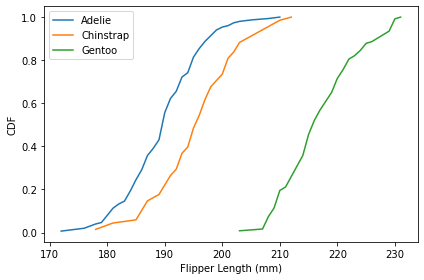

In [4]:
colname = 'Flipper Length (mm)'
plot_cdfs(df, colname)

In the above it looks like we could use `Flipper length` to separate `Adelie, Chinstrap` from  `Gentoo`

### Bayesian Classification

1) Define a prior distribution w/ 3 possible species and prior probability for each
2) Compute likelihood of the data for each hypoethical species (based on feature info)
- Use sample data for each species to build a normal distribution across each feature
- Can then use the `pdf` of each normal distribution as a proxy for th likelihood 

3) Compute posterior probability



In [5]:
from scipy.stats import norm

def make_norm_map(df, colname, by='Species2'):
    """Make a map from species to norm object."""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

flipper_map = make_norm_map(df, 'Flipper Length (mm)')
flipper_map.keys()

dict_keys(['Adelie', 'Chinstrap', 'Gentoo'])

In [6]:
print(flipper_map['Adelie'].pdf(193))  # how do we interpret this? 

0.054732511875530694


In [7]:
print(flipper_map['Adelie'].pdf(199))  # how do we interpret this? 

0.023432738035235042


In [8]:
print(flipper_map['Adelie'].pdf(183))

0.03466118647063332


As the author states the PDF is not a likelihood, but he is treating this just as proportional to the likelihood of the data. We see as we pass in a value close to the mean we get a higher PDF value, and similarly moving to the tails gives a lower value so this is a fair approximation.

In [9]:
data = 210 # we know that Gentoo have the largest flipper, so we would expect a higher likelihood for gentoo
hypos = flipper_map.keys()
likelihood = [(flipper_map[hypo].pdf(data), hypo) for hypo in hypos]
likelihood

[(0.0005557043153857454, 'Adelie'),
 (0.007757433347055787, 'Chinstrap'),
 (0.03328865501748979, 'Gentoo')]

### Update

Let's assume we have a penguin and are given information about it, how does this process work

In [10]:
from empiricaldist import Pmf

# assume equal
prior = Pmf(1/3, hypos)
prior

,probs
Adelie,0.333333
Chinstrap,0.333333
Gentoo,0.333333


In [11]:
data = 193
hypos = flipper_map.keys()
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]

posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


In [12]:
# cleaner version
def update_penguin(prior, data, norm_map):
    """Update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

,probs
Adelie,0.513860
Chinstrap,0.485589
Gentoo,0.000551


In [13]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')
posterior2 = update_penguin(prior, 40, culmen_map) # culmen of 40 in CDF plot should be linked to Adelie
posterior2

,probs
Adelie,0.929274
Chinstrap,0.024829
Gentoo,0.045896


### Naive Bayesian Classification

The below is just going to allow for multiple updates of the posterior, meaning more than just one feature. 

In [14]:
def update_naive(prior, data_seq, norm_maps):
    """Naive Bayesian classifier
    
    prior: Pmf
    data_seq: sequence of measurements
    norm_maps: sequence of maps from species to distribution
    
    returns: Pmf representing the posterior distribution
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps): # combine so we can iterate through data and 
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

In [15]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]

# we see data of: 193 for Flipper, 48 for Culment
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie,0.003455
Chinstrap,0.995299
Gentoo,0.001246


In [16]:
import numpy as np

df['Classification'] = np.nan

# we can actually iterate through each row and pass in the features of interest and generate a posterior for each
# posterior max_prob is then going to yield the most likely classification
for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

In [17]:
def accuracy(df):
    """Compute the accuracy of classification."""
    valid = df['Classification'].notna()
    same = df['Species2'] == df['Classification']
    return same.sum() / valid.sum()

accuracy(df)

0.9473684210526315

### Joint Distributions:



In [18]:
from cycler import cycler

Pu50 = (0.46, 0.406, 0.685, 0.7)
Gr30 = (0.0, 0.312, 0.125, 0.7)
Or70 = (0.966, 0.475, 0.147, 0.7)

color_list3 = [Or70, Pu50, Gr30]

marker_cycle = cycler(marker=['s', 'o', '^'])
color_cycle = cycler(color=color_list3)
line_cycle = cycler(linestyle=['-', '--', ':'])

plt.rcParams['axes.prop_cycle'] = (color_cycle + 
                                   marker_cycle + 
                                   line_cycle)

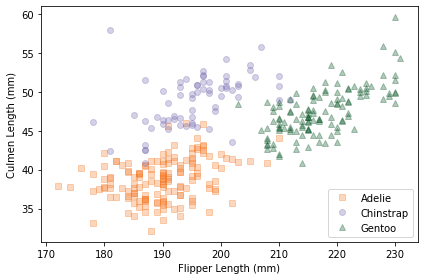

In [19]:
def scatterplot(df, var1, var2):
    """Make a scatter plot."""
    grouped = df.groupby('Species2')
    for species, group in grouped:
        plt.plot(group[var1], group[var2],
                 label=species, lw=0, alpha=0.3)
    
    decorate(xlabel=var1, ylabel=var2)
    
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2);

#### Finding:

We actually see that there likely is some relionship between culmen length and flipper length due to the oval nature of the joint distribution. There is additional information we can squeeze out of moving away from the naive (independent) view of these features.

To prove this out below we can see how our joint distribution looks if we do assume independence, meaning we jhust build out a Pmf approx of normal distribution.

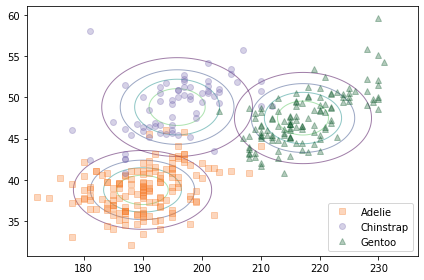

In [20]:
def make_pmf_norm(dist, sigmas=3, n=101):
    """Make a Pmf approximation to a normal distribution."""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

def make_joint(s1, s2):
    """Compute the outer product of two Series.
    First Series goes across the columns;
    second goes down the rows.
    s1: Series
    s2: Series
    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

joint_map = {}
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)
    
def underride(d, **options):
    """Add key-value pairs to d only if key is not in d.
    d: dictionary
    options: keyword args to add to d
    """
    for key, val in options.items():
        d.setdefault(key, val)

    return d

def plot_contour(joint, **options):
    """Plot a joint distribution.
    joint: DataFrame representing a joint PMF
    """
    low = joint.to_numpy().min()
    high = joint.to_numpy().max()
    levels = np.linspace(low, high, 6)
    levels = levels[1:]

    underride(options, levels=levels, linewidths=1)
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name,
             ylabel=joint.index.name)
    return cs

scatterplot(df, var1, var2)
for species in hypos:
    plot_contour(joint_map[species], alpha=0.5)

#### Takeaway

The contours are not well aligned with the data because the features are actually correlated, so our approximation is not great. We can improve our model by using a `multivariate normal distribution`


### Multivariate Normal Distribution

- means of features
- covariance matrix: contains variances (spread of feature) and covariances (relationships between features)

Author note: variances & covariances are not easy to interpret in isolation, we typically use them to calculation standard deviations and correlation coefficients. 

In [21]:
features = df[[var1, var2]]
mean = features.mean()
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


In [22]:
from scipy.stats import multivariate_normal

def make_multinorm_map(df, colnames):
    """Make a map from each species to a multivariate normal."""
    multinorm_map = {}
    grouped = df.groupby('Species2')
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

multinorm_map = make_multinorm_map(df, [var1, var2]) # build for two features

In [23]:
def make_joint(norm1, norm2, multinorm):
    """Make a joint distribution.
    
    norm1: `norm` object representing the distribution of the first feature
    norm2: `norm` object representing the distribution of the second feature
    multinorm: `multivariate_normal` object representing the joint distribution
    """
    pmf1 = make_pmf_norm(norm1)
    pmf2 = make_pmf_norm(norm2)
    X, Y = np.meshgrid(pmf1.qs, pmf2.qs)
    pos = np.dstack((X, Y))
    densities = multinorm.pdf(pos)
    joint = pd.DataFrame(densities, columns=pmf1.qs, index=pmf2.qs)
    return joint

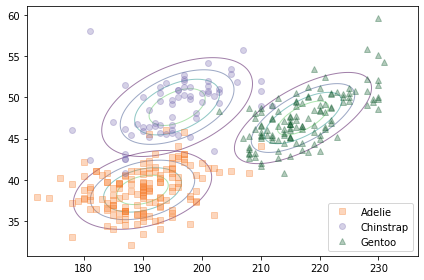

In [24]:
scatterplot(df, var1, var2)

for species in hypos:
    norm1 = flipper_map[species]
    norm2 = culmen_map[species]
    multinorm = multinorm_map[species]
    joint = make_joint(norm1, norm2, multinorm)
    plot_contour(joint, alpha=0.5)

#### Takeaway:

The multivariate normal distribution is taking into account correlations between features so it is a better representation of our data. 

We see the contours are well-separated, meaning we likely can discriminate classes better (which we see below)

In [25]:
data = 193, 48
update_penguin(prior, data, multinorm_map) # we use multinorm object

,probs
Adelie,0.002740
Chinstrap,0.997257
Gentoo,0.000003


In [26]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()
    
accuracy(df) # slightly improved

0.9532163742690059